## Covid-19: Análisis del progreso de la vacunación mundial

In [ ]:
!pip install a-world-of-countries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import awoc
import numpy as np
import sklearn
from sklearn import datasets
import plotly.graph_objs as go

import pandas_profiling as pp
import pandas.util.testing as tm

import kaggle
import os

C:\Users\ywen2\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import zipfile

In [3]:
kaggle.api.authenticate()

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = "carlosbgdlv" # username from the json file
os.environ['KAGGLE_KEY'] = "872fe59349b4da02f837f243c6533328" # key from the json file

In [5]:
#!kaggle datasets download gpreda/covid-world-vaccination-progress -f country_vaccinations
!kaggle datasets download gpreda/covid-world-vaccination-progress -f country_vaccinations_by_manufacturer.csv --force
!kaggle datasets download gpreda/covid-world-vaccination-progress -f country_vaccinations.csv --force


  0%|          | 0.00/119k [00:00<?, ?B/s]
100%|##########| 119k/119k [00:00<00:00, 1.95MB/s]



  0%|          | 0.00/306k [00:00<?, ?B/s]
100%|##########| 306k/306k [00:00<00:00, 2.61MB/s]
100%|##########| 306k/306k [00:00<00:00, 2.61MB/s]


In [6]:
path_to_zip_file = "C:/Users/ywen2/Desktop/URJC/BACKUP PROCESADO/country_vaccinations.csv.zip"
directory_to_extract_to= "C:/Users/ywen2/Desktop/URJC/BACKUP PROCESADO"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [7]:
df = pd.read_csv("country_vaccinations.csv")
df2 = pd.read_csv("covid19_country_population.csv")
df_manufacturers = ("country_vaccinations_by_manufacturer.csv")

#### Variables


1. **Country:** es el país para el que se proporciona la información sobre la vacunación;
2. **Country ISO Code** - código ISO del país;
3. **Fecha** - fecha para la entrada de datos; para algunas de las fechas tenemos sólo las vacunas diarias, para otras, sólo el total (acumulado);
3. **Total number of vaccinations** - es el número absoluto de vacunas totales en el país;
4. **Total number of people vaccinated** - una persona, dependiendo del esquema de vacunación, recibirá una o más (normalmente 2) vacunas; en un momento dado, el número de vacunaciones puede ser mayor que el número de personas;
5. **Número total de personas totalmente vacunadas** - es el número de personas que recibieron todo el conjunto de vacunas según el esquema de inmunización (típicamente 2); en un momento determinado, puede haber un cierto número de personas que recibieron una vacuna y otro número (menor) de personas que recibieron todas las vacunas del esquema;
6. **Daily vaccinations (raw):** para una determinada entrada de datos, el número de vacunaciones para esa fecha/país;
7. **Daily vaccinations:** para una determinada entrada de datos, el número de vacunaciones para esa fecha/país;
8. **Total vaccinations per hundred** - relación (en porcentaje) entre el número de vacunaciones y la población total hasta la fecha en el país;
9. **Total number of people vaccinated per hundred**  - relación (en porcentaje) entre la población vacunada y la población total hasta la fecha en el país;
10. **Total number of people fully vaccinated per hundred** - relación (en porcentaje) entre la población totalmente vacunada y la población total hasta la fecha en el país;
11. **Number of vaccinations per day** - número de vacunaciones diarias para ese día y país;
    Daily vaccinations per million  - relación (en ppm) entre el número de vacunaciones y la población total para la fecha en el país;
12. **Vaccines** - El tipo de vacunas utilizadas en el país;
13. **Source name** - fuente de la información (autoridad nacional, organización internacional, organización local, etc.);
14. **Source website**  - sitio web de la fuente de información.


In [8]:
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...


In [9]:
df2.head()

,CountryAlpha3Code,Population
0,ABW,106314.0
1,AFG,38041754.0
2,AGO,31825295.0
3,ALB,2854191.0
4,AND,77142.0


In [ ]:
#getting a profile summary
pp.ProfileReport(df)

In [10]:
df2 = df2.rename(columns={'CountryAlpha3Code': 'iso_code'})

Eliminamos la columna daily_vaccinations_raw, ya que es una versión "a sucio" de daily_vaccinations

In [11]:
df = df.drop('daily_vaccinations_raw', axis=1)

Ponemos la fecha en nuestro formato y ordenamos los datos por fechas de vacunación (de la más antigua a la más actual)

In [12]:
df.dtypes

country                                 object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
daily_vaccinations_per_million         float64
vaccines                                object
source_name                             object
source_website                          object
dtype: object

In [13]:
df['date'] = pd.to_datetime(df['date'])
#df = df.sort_values('date', ascending=True)

df['date'] = df['date'].dt.strftime('%Y-%m-%d')

In [14]:
df[['date']] = df[['date']].apply(pd.to_datetime)

In [15]:
df.dtypes

country                                        object
iso_code                                       object
date                                   datetime64[ns]
total_vaccinations                            float64
people_vaccinated                             float64
people_fully_vaccinated                       float64
daily_vaccinations                            float64
total_vaccinations_per_hundred                float64
people_vaccinated_per_hundred                 float64
people_fully_vaccinated_per_hundred           float64
daily_vaccinations_per_million                float64
vaccines                                       object
source_name                                    object
source_website                                 object
dtype: object

In [16]:
df['country'] = df['country'].astype(str)
df['iso_code'] = df['iso_code'].astype(str)
df['vaccines'] = df['vaccines'].astype(str)
df['source_name'] = df['source_name'].astype(str)
df['source_website'] = df['source_website'].astype(str)

In [17]:
df.dtypes

country                                        object
iso_code                                       object
date                                   datetime64[ns]
total_vaccinations                            float64
people_vaccinated                             float64
people_fully_vaccinated                       float64
daily_vaccinations                            float64
total_vaccinations_per_hundred                float64
people_vaccinated_per_hundred                 float64
people_fully_vaccinated_per_hundred           float64
daily_vaccinations_per_million                float64
vaccines                                       object
source_name                                    object
source_website                                 object
dtype: object

In [18]:
# Combining the two datasets using pd.join, ensuring that three common columns are used as the index.

#df_1 = df.set_index(['iso_code', 'date'])
df_1 = df.set_index('iso_code')
df_2 = df2.set_index('iso_code')
covid_vaccine_data = df_1.join(df_2)
covid_vaccine_data.head(5)

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Population
iso_code,,,,,,,,,,,,,,
ABW,Aruba,2021-03-29,25766.0,15600.0,10166.0,NaN,24.13,14.61,9.52,NaN,Pfizer/BioNTech,Government of Aruba,https://www.government.aw,106314.0
ABW,Aruba,2021-03-30,NaN,NaN,NaN,1278.0,NaN,NaN,NaN,11970.0,Pfizer/BioNTech,Government of Aruba,https://www.government.aw,106314.0
ABW,Aruba,2021-03-31,NaN,NaN,NaN,1278.0,NaN,NaN,NaN,11970.0,Pfizer/BioNTech,Government of Aruba,https://www.government.aw,106314.0
ABW,Aruba,2021-04-01,NaN,NaN,NaN,1278.0,NaN,NaN,NaN,11970.0,Pfizer/BioNTech,Government of Aruba,https://www.government.aw,106314.0
ABW,Aruba,2021-04-02,NaN,NaN,NaN,1278.0,NaN,NaN,NaN,11970.0,Pfizer/BioNTech,Government of Aruba,https://www.government.aw,106314.0


In [19]:
print('Data point starts from ',covid_vaccine_data.date.min(),'\n')
print('Data point ends at ',covid_vaccine_data.date.max(),'\n')
print('Total no of countries in the data set ',len(covid_vaccine_data.country.unique()),'\n')
print('Total no of unique vaccines in the data set ',len(covid_vaccine_data.vaccines.unique()),'\n')

Data point starts from  2020-12-14 00:00:00 

Data point ends at  2021-04-27 00:00:00 

Total no of countries in the data set  193 

Total no of unique vaccines in the data set  34 



Con unique_dates podemos saber que días se ha vacunado (teniendo en cuenta todos los países)

In [20]:
covid_vaccine_data['vaccines'].unique()

array(['Pfizer/BioNTech', 'Oxford/AstraZeneca',
       'Pfizer/BioNTech, Sinovac', 'Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sinopharm/Wuhan, Sputnik V',
       'Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V', 'Sputnik V',
       'Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech',
       'Sinovac', 'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, Sputnik V',
       'Oxford/AstraZeneca, Sinovac', 'Moderna, Pfizer/BioNTech',
       'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac', 'Sinopharm/Beijing',
       'Sinopharm/Beijing, Sputnik V',
       'Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac',
       'Oxford/AstraZeneca, Sinopharm/Beijing',
       'Moderna, Oxford/AstraZeneca',
       'Moderna, Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V',
       'Covaxin, Oxford/Ast

In [21]:
unique_dates = df['date'].unique()
#unique_dates = covid_vaccine_data['date'].unique()
type(unique_dates[0])

numpy.datetime64

In [22]:
covid_vaccine_data.sort_values(by = 'date')

,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,Population
iso_code,,,,,,,,,,,,,,
CAN,Canada,2020-12-14,5.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Official data from provinces via covid19tracke...,https://covid19tracker.ca/vaccinationtracker.html,3.758926e+07
RUS,Russia,2020-12-15,28500.0,28500.0,NaN,NaN,0.02,0.02,NaN,NaN,"EpiVacCorona, Sputnik V",Official data from local governments via gogov.ru,https://gogov.ru/articles/covid-v-stats,1.443735e+08
CAN,Canada,2020-12-15,723.0,NaN,NaN,718.0,0.00,NaN,NaN,19.0,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech",Official data from provinces via covid19tracke...,https://covid19tracker.ca/vaccinationtracker.html,3.758926e+07
CHN,China,2020-12-15,1500000.0,NaN,NaN,NaN,0.10,NaN,NaN,NaN,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",National Health Commission,http://www.nhc.gov.cn/xcs/yqjzqk/202104/6fa3e9...,1.397715e+09
CHN,China,2020-12-16,NaN,NaN,NaN,187500.0,NaN,NaN,NaN,130.0,"Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac",National Health Commission,http://www.nhc.gov.cn/xcs/yqjzqk/202104/6fa3e9...,1.397715e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC,Macao,2021-04-27,98021.0,64047.0,34109.0,1859.0,15.10,9.86,5.25,2863.0,"Pfizer/BioNTech, Sinopharm/Beijing",Government of Macao,https://www.gov.mo/zh-hant/news/374842/,6.404450e+05
GEO,Georgia,2021-04-27,40095.0,40095.0,NaN,1297.0,1.01,1.01,NaN,325.0,Oxford/AstraZeneca,Government of Georgia,https://www.facebook.com/ncdcgeorgia/photos/a....,3.720382e+06
LVA,Latvia,2021-04-27,269517.0,227436.0,42096.0,6311.0,14.29,12.06,2.23,3346.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",National Health Service,https://data.gov.lv/dati/eng/dataset/covid19-v...,1.912789e+06


## Preprocesado

### Missing Data

Veamos el número de NaN que tenemos por columnas

In [26]:
covid_vaccine_data.isnull().sum()/len(covid_vaccine_data)*100

country                                 0.000000
date                                    0.000000
total_vaccinations                     40.365425
people_vaccinated                      44.834856
people_fully_vaccinated                59.718904
daily_vaccinations                      1.384399
total_vaccinations_per_hundred         40.365425
people_vaccinated_per_hundred          44.834856
people_fully_vaccinated_per_hundred    59.718904
daily_vaccinations_per_million          1.384399
vaccines                                0.000000
source_name                             0.000000
source_website                          0.000000
Population                              7.589599
dtype: float64

In [27]:
print("Vaccination date starts from ",unique_dates[0]," till ",unique_dates[-1])
print("Total Countries vaccinated :",len(covid_vaccine_data["country"].unique()))
print("Total Vaccines  :",len(covid_vaccine_data["vaccines"].unique()))

Vaccination date starts from  2021-02-22T00:00:00.000000000  till  2020-12-22T00:00:00.000000000
Total Countries vaccinated : 193
Total Vaccines  : 34


In [28]:
covid_vaccine_data.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,Population
count,8.486000e+03,7.850000e+03,5.732000e+03,1.403300e+04,8486.000000,7850.000000,5732.000000,14033.000000,1.315000e+04
mean,4.611201e+06,3.001720e+06,1.467278e+06,7.496936e+04,14.723686,10.781958,5.360661,2952.381886,5.355762e+07
std,1.870498e+07,1.112719e+07,6.349924e+06,3.321700e+05,22.557198,14.904388,9.772984,4770.202889,1.882513e+08
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.258100e+04
25%,5.631175e+04,4.976875e+04,2.222525e+04,9.120000e+02,1.230000,1.140000,0.600000,350.000000,2.083459e+06
50%,3.977390e+05,3.100695e+05,1.619255e+05,6.003000e+03,5.870000,4.580000,2.180000,1457.000000,8.877067e+06
75%,1.840986e+06,1.295492e+06,6.503910e+05,2.775100e+04,18.490000,13.727500,5.740000,3814.000000,3.426853e+07
max,2.359760e+08,1.417519e+08,9.674745e+07,5.289429e+06,204.070000,109.000000,95.060000,118759.000000,1.397715e+09


In [29]:
covid_vaccine_data.columns

Index(['country', 'date', 'total_vaccinations', 'people_vaccinated',
       'people_fully_vaccinated', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million',
       'vaccines', 'source_name', 'source_website', 'Population'],
      dtype='object')

In [31]:
covid_vaccine_data.isnull().sum()

country                                   0
date                                      0
total_vaccinations                     5744
people_vaccinated                      6380
people_fully_vaccinated                8498
daily_vaccinations                      197
total_vaccinations_per_hundred         5744
people_vaccinated_per_hundred          6380
people_fully_vaccinated_per_hundred    8498
daily_vaccinations_per_million          197
vaccines                                  0
source_name                               0
source_website                            0
Population                             1080
dtype: int64

In [32]:
covid_vaccine_data.dtypes

country                                        object
date                                   datetime64[ns]
total_vaccinations                            float64
people_vaccinated                             float64
people_fully_vaccinated                       float64
daily_vaccinations                            float64
total_vaccinations_per_hundred                float64
people_vaccinated_per_hundred                 float64
people_fully_vaccinated_per_hundred           float64
daily_vaccinations_per_million                float64
vaccines                                       object
source_name                                    object
source_website                                 object
Population                                    float64
dtype: object

#### Interpolación lineal

In [33]:
#interpolación de NaN

covid_vaccine_data['daily_vaccinations']= covid_vaccine_data['daily_vaccinations'].interpolate(method='linear')
covid_vaccine_data['total_vaccinations']= covid_vaccine_data['total_vaccinations'].interpolate(method='linear')
covid_vaccine_data['people_vaccinated']= covid_vaccine_data['people_vaccinated'].interpolate(method='linear')

covid_vaccine_data['people_fully_vaccinated']= covid_vaccine_data['people_fully_vaccinated'].interpolate(method='linear')
covid_vaccine_data['total_vaccinations_per_hundred']= covid_vaccine_data['total_vaccinations_per_hundred'].interpolate(method='linear')
covid_vaccine_data['people_vaccinated_per_hundred']= covid_vaccine_data['people_vaccinated_per_hundred'].interpolate(method='linear')

covid_vaccine_data['people_fully_vaccinated_per_hundred']= covid_vaccine_data['people_fully_vaccinated_per_hundred'].interpolate(method='linear')
covid_vaccine_data['daily_vaccinations_per_million']= covid_vaccine_data['daily_vaccinations_per_million'].interpolate(method='linear')


In [34]:
covid_vaccine_data.isnull().sum()

country                                   0
date                                      0
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                   0
daily_vaccinations                        1
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred       0
daily_vaccinations_per_million            1
vaccines                                  0
source_name                               0
source_website                            0
Population                             1080
dtype: int64


### ORDENAMOS SEGUN CONTINENTES (UN DATA FRAME PARA CADA CONTINENTE)



In [35]:
# Initialize the AWOC class.
my_world = awoc.AWOC()

#### Europe

In [36]:
nations_of_europe = my_world.get_countries_list_of('Europe')

In [37]:
europe = covid_vaccine_data[covid_vaccine_data['country'].isin(nations_of_europe)]

#### Asia

In [38]:
nations_of_asia = my_world.get_countries_list_of('Asia')

In [39]:
asia = covid_vaccine_data[covid_vaccine_data['country'].isin(nations_of_asia)]
print(asia.shape)

(3255, 14)


#### Africa

In [40]:
nations_of_africa = my_world.get_countries_list_of('Africa')

In [41]:
africa = covid_vaccine_data[covid_vaccine_data['country'].isin(nations_of_africa)]
print(africa.shape)

(1546, 14)


#### Norte América

In [42]:
nations_of_north_america = my_world.get_countries_list_of('North America')

In [43]:
north_america = covid_vaccine_data[covid_vaccine_data['country'].isin(nations_of_north_america)]
print(north_america.shape)

(2163, 14)


# **EDA**

### 1.Progreso del número de inmunizaciones

VAMOS A OBTENER EL PAÍS DE CADA CONTINENTE CON MAYOR NÚMERO DE PERSONAS VACUNADAS Y COMPARARLOS ENTRE SI. 

In [44]:
max_ = europe[europe['total_vaccinations'] == np.max(europe['total_vaccinations'])][['country','total_vaccinations']]
max_1 = africa[africa['total_vaccinations'] == np.max(africa['total_vaccinations'])][['country','total_vaccinations']]
max_2 = asia[asia['total_vaccinations'] == np.max(asia['total_vaccinations'])][['country','total_vaccinations']]
max_3 = north_america[north_america['total_vaccinations'] == np.max(north_america['total_vaccinations'])][['country','total_vaccinations']]


print(max_)
print(max_1)
print(max_2)
print(max_3)

                 country  total_vaccinations
iso_code                                    
GBR       United Kingdom          47045391.0
          country  total_vaccinations
iso_code                             
MAR       Morocco           9041985.0
         country  total_vaccinations
iso_code                            
CHN        China         235976000.0
                country  total_vaccinations
iso_code                                   
USA       United States         232407669.0


Número de pacientes vacunados por país (elegimos el continente del que queremos obtener los datos)

In [45]:
res = europe.groupby("country")["total_vaccinations"].agg(Numero_pacientes_vacunados="max")
#print(res)

In [46]:
vacc_GBR = europe.loc[europe.country == 'United Kingdom']
vacc_Morocco = africa.loc[africa.country == 'Morocco']
vacc_China = asia.loc[asia.country == 'China']
vacc_United_States = north_america.loc[north_america.country == 'United States']
total_vaccination = pd.concat([vacc_GBR, vacc_Morocco, vacc_China, vacc_United_States])

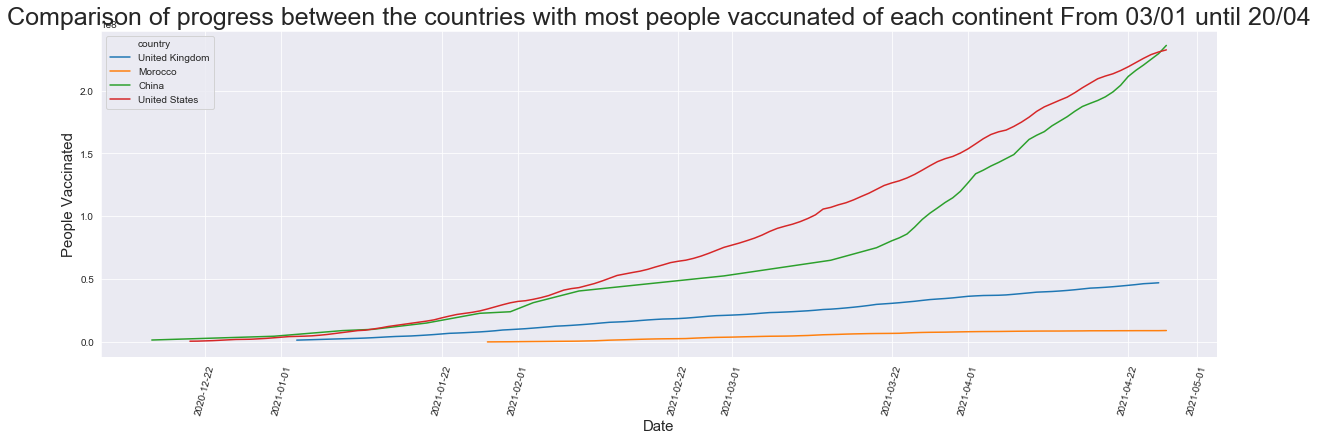

In [47]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,6))
sns.lineplot(data= total_vaccination, x='date', y='total_vaccinations', hue = 'country', palette = 'tab10')
plt.xticks(rotation=75)
plt.title('Comparison of progress between the countries with most people vaccunated of each continent From 03/01 until 20/04',fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('People Vaccinated', fontsize=15)
plt.show()

### 2.Daily vaccinations

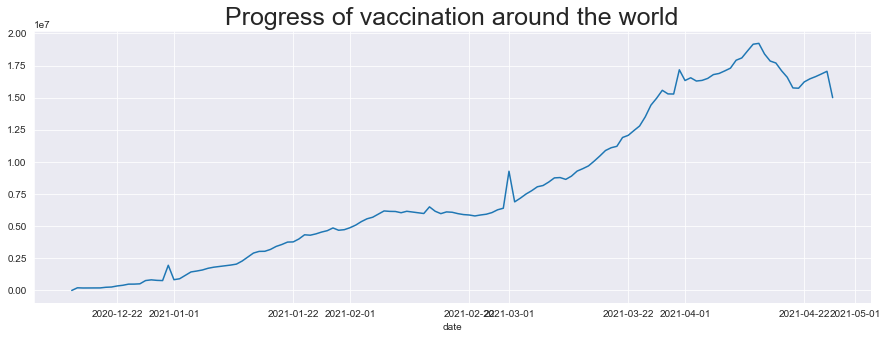

In [48]:
#daily vaccinations en todo el mundo
x= covid_vaccine_data.groupby("date").daily_vaccinations.sum()
plt.figure(figsize= (15,5))
sns.lineplot(x.index,x.values)
plt.title('Progress of vaccination around the world',fontsize=25)
plt.show()

### 3. Población con mayor número de pacientes vacunados con las dos dosis

Además, también podemos estudiar en qué país está más avanzado el programa de vacunación. Para ello, tenemos que centrarnos en la variable **"people_fully_vaccinated_per_hundred"**. Esta varible refleja el ratio de la población totalmente inmunizada y la población total hasta la fecha en el país. Es importante tener en consideración este ratio porque no todos los países tienen la misma cantidad de población.


In [49]:
max_ = europe[europe['people_fully_vaccinated_per_hundred'] == np.max(europe['people_fully_vaccinated_per_hundred'])][['country','people_fully_vaccinated_per_hundred']]
max_1 = africa[africa['people_fully_vaccinated_per_hundred'] == np.max(africa['people_fully_vaccinated_per_hundred'])][['country','people_fully_vaccinated_per_hundred']]
max_2 = asia[asia['people_fully_vaccinated_per_hundred'] == np.max(asia['people_fully_vaccinated_per_hundred'])][['country','people_fully_vaccinated_per_hundred']]
max_3 = north_america[north_america['people_fully_vaccinated_per_hundred'] == np.max(north_america['people_fully_vaccinated_per_hundred'])][['country','people_fully_vaccinated_per_hundred']]

print(max_)
print(max_1)
print(max_2)
print(max_3)

            country  people_fully_vaccinated_per_hundred
iso_code                                                
GIB       Gibraltar                                95.06
         country  people_fully_vaccinated_per_hundred
iso_code                                             
GIN       Guinea                                63.38
         country  people_fully_vaccinated_per_hundred
iso_code                                             
ISR       Israel                                58.63
                           country  people_fully_vaccinated_per_hundred
iso_code                                                               
TCA       Turks and Caicos Islands                            47.233729


In [50]:
res = europe.groupby("country")["people_fully_vaccinated_per_hundred"].agg(Numero_pacientes_vacunados="max")
vacc_Gibraltar = europe.loc[europe.country == 'Gibraltar']
vacc_Seychelles = africa.loc[africa.country == 'Seychelles']
vacc_Israel = asia.loc[asia.country == 'Israel']
vacc_Cayman = north_america.loc[north_america.country == 'Cayman Islands']
inmunized = pd.concat([vacc_Gibraltar, vacc_Seychelles, vacc_Israel, vacc_Cayman])

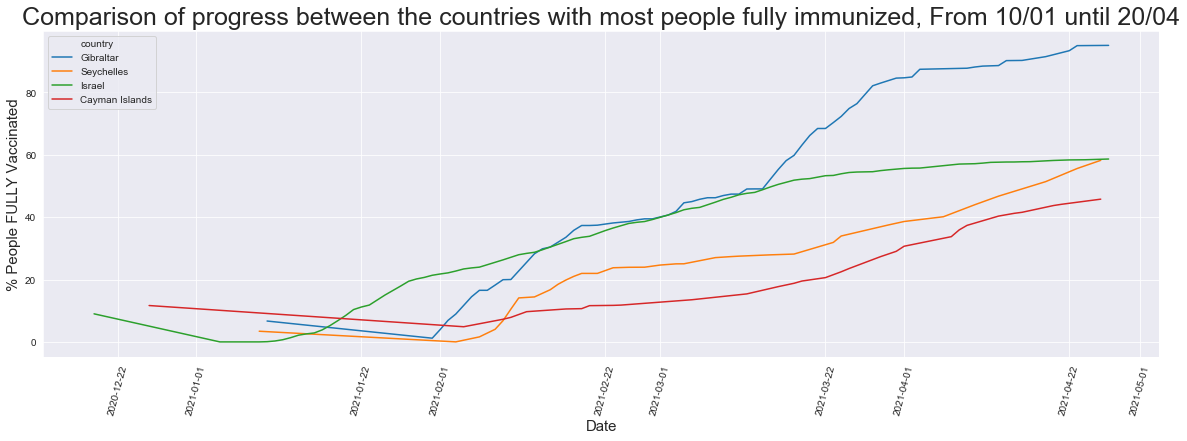

In [51]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,6))
sns.lineplot(data= inmunized, x='date', y='people_fully_vaccinated_per_hundred', hue = 'country', palette = 'tab10')
plt.xticks(rotation=75)
plt.title('Comparison of progress between the countries with most people fully immunized, From 10/01 until 20/04',fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('% People FULLY Vaccinated', fontsize=15)
plt.show()

De este gráfico se pueden deducir varias cosas:

- El país que está más avanzado en su campaña de población es Gibraltar. Una de las razones principales a las que se debe esto, es que Gibraltar es un territorio pequeño (6,8 km^2) con una población de alrededor de 33000 personas. Se observa como alcanza la inmunidad de rebaño (70%) a mediados de marzo y continua subiendo. 

- Por otro lado, el segundo del mundo con mayor porcentaje de población totalmente inmunizada es Israel. Se aprecia como tiene un crecimiento bastante constante a medida que pasa el tiempo, hasta llegar a una estepa poco antes del 60%. **(El tramo verde en el que está todo a cero corresponde a diciembre de 2020 en el que no existía ninguna persona inmunizada, es un error de representación.**

- Las islas Caimán y las Seychelles comienzan su vacunación un poco más tarde, pero al ser también territorios con menos de 100000 personas, su ratio de inmunización es más elevado que otros territorios de su mismo continente. 

### 4. Top countries with fully  vaccinated people

In [52]:
covid_vaccine_data["Full_vaccinations(count)"] = covid_vaccine_data.groupby("country").people_fully_vaccinated.tail(1)
covid_vaccine_data.groupby("country")["Full_vaccinations(count)"].mean().sort_values(ascending= False).head(20)

country
United States                       9.674745e+07
Uzbekistan                          8.237388e+07
Saint Vincent and the Grenadines    6.081352e+07
Venezuela                           3.040789e+07
India                               2.361595e+07
United Kingdom                      1.320181e+07
Brazil                              1.224825e+07
England                             1.104162e+07
Turkey                              8.295424e+06
Indonesia                           7.214534e+06
Russia                              6.958027e+06
Barbados                            6.779099e+06
Brunei                              6.393948e+06
Chile                               6.328743e+06
Mexico                              6.096954e+06
Germany                             6.038063e+06
Djibouti                            5.919676e+06
France                              5.702509e+06
Rwanda                              5.543238e+06
Italy                               5.430357e+06
Name: Full_v

In [53]:
fig = go.Figure(data=go.Choropleth(locations = covid_vaccine_data['country'],
                            locationmode='country names',
                            z = covid_vaccine_data["Full_vaccinations(count)"],
                            text = covid_vaccine_data['country'],       
                            colorscale = 'Reds',
                            autocolorscale=False,
                            marker_line_color='darkgray',
                            marker_line_width=0.5,
                        
                          ))

fig.update_layout(
    title_text='MAPA DE VACUNACIONES TOTALES',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ))
fig.show()

In [54]:
covid_vaccine_data["Total_vaccinations(count)"] = covid_vaccine_data.groupby("country").total_vaccinations.tail(1)
covid_vaccine_data.groupby("country")["Total_vaccinations(count)"].mean().sort_values(ascending= False).head(20)

country
China                   235976000.0
United States           232407669.0
India                   144879233.0
United Kingdom           47045391.0
Brazil                   40168799.0
England                  39398398.0
Germany                  25892613.0
Turkey                   21678461.0
France                   20014256.0
Indonesia                19230446.0
Russia                   18557064.0
Italy                    18502829.0
Mexico                   16687189.0
Spain                    14994667.0
Chile                    14324489.0
Canada                   12564325.0
Poland                   10740169.0
Israel                   10468200.0
United Arab Emirates     10336214.0
Morocco                   9041985.0
Name: Total_vaccinations(count), dtype: float64

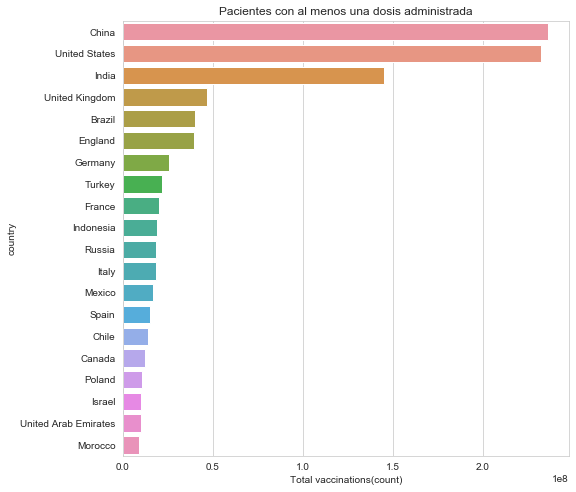

In [58]:
x= covid_vaccine_data.groupby("country")["Total_vaccinations(count)"].mean().sort_values(ascending= False).head(20)
sns.set_style("whitegrid")
plt.figure(figsize= (8,8))
ax= sns.barplot(x.values,x.index)
ax.set_xlabel("Total vaccinations(count)")
plt.title('Pacientes con al menos una dosis administrada')
plt.show()

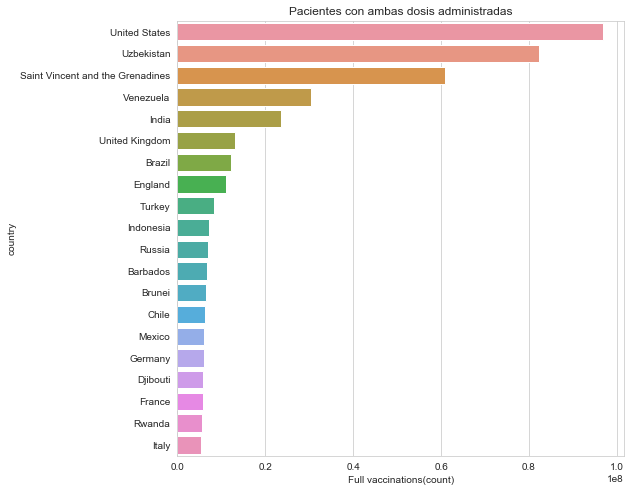

In [57]:
x= covid_vaccine_data.groupby("country")["Full_vaccinations(count)"].mean().sort_values(ascending= False).head(20)
sns.set_style("whitegrid")
plt.figure(figsize= (8,8))
ax= sns.barplot(x.values,x.index)
ax.set_xlabel("Full vaccinations(count)")
plt.title('Pacientes con ambas dosis administradas')
plt.show()

### 5. Correlación

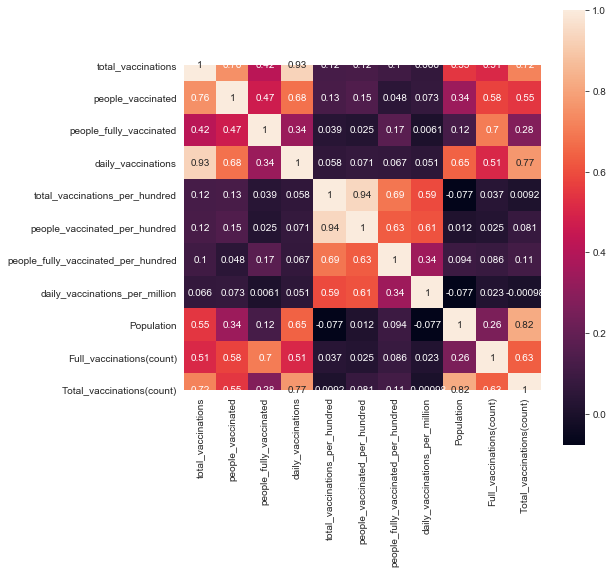

In [59]:
#correlation
plt.subplots(figsize=(8, 8))
sns.heatmap(covid_vaccine_data.corr() , annot=True, square=True )
plt.show()

# OBSEVANDO EL MAPA DE CORRELACIÓN PODEMOS DEDUCIR QUE LAS VARIABLES TOTAL_VACCINATION Y PEOPLE_VACCINATED NOS APORTAN LA MISMA INFORMACIÓN (0.99 DE CORRELACIÓN)

### 6. Vacunas

Encontrar cuales son los países que más han utilizado un tipo de vacuna. 

In [60]:
#most common vaccines
covid_vaccine_data.vaccines.value_counts()

Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                          2667
Oxford/AstraZeneca                                                                    2400
Pfizer/BioNTech                                                                       1458
Oxford/AstraZeneca, Pfizer/BioNTech                                                   1065
Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                          963
Moderna, Pfizer/BioNTech                                                               563
Pfizer/BioNTech, Sinovac                                                               533
Oxford/AstraZeneca, Sinopharm/Beijing                                                  468
Sputnik V                                                                              411
Oxford/AstraZeneca, Sinovac                                                            396
Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac                                           388

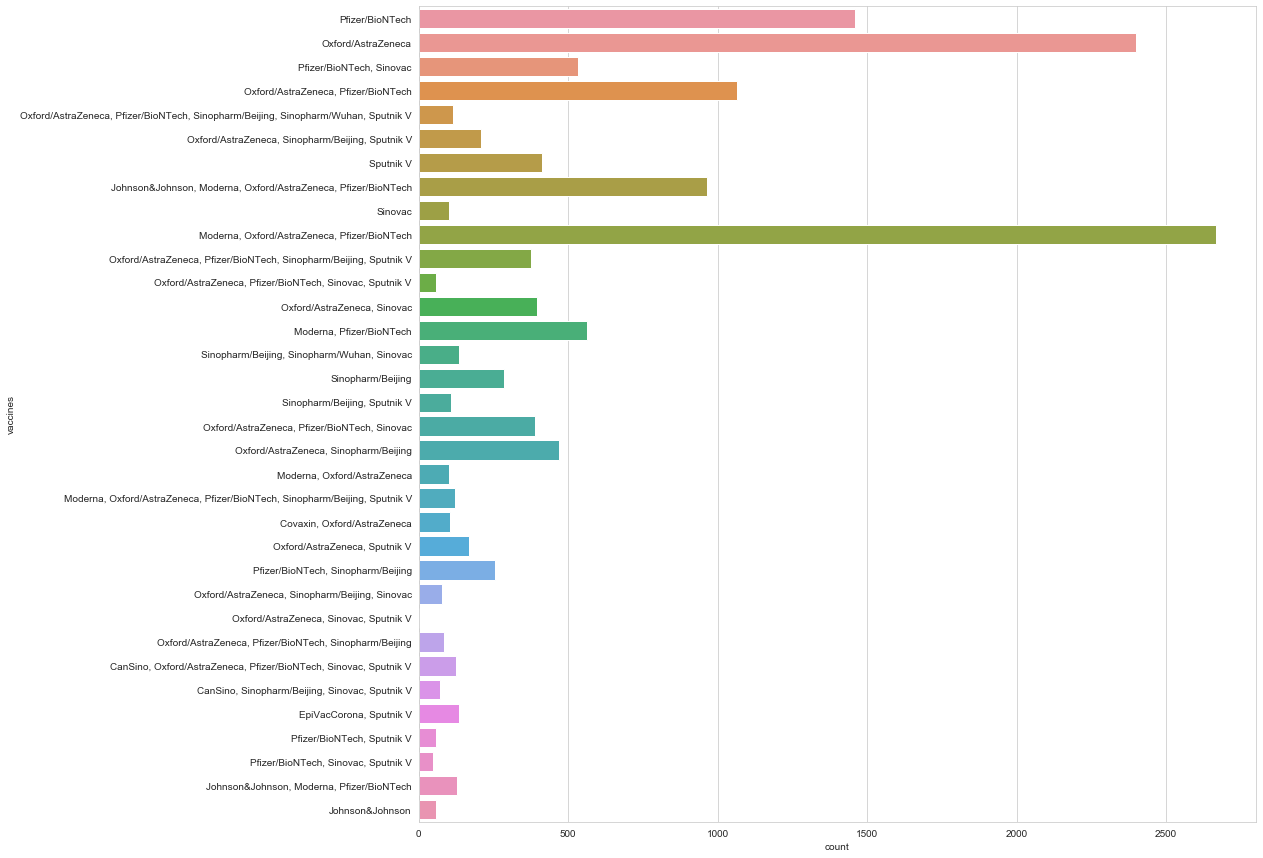

In [61]:
plt.figure(figsize=(15,15))
sns.countplot(y= "vaccines",data= covid_vaccine_data)
plt.show()

In [62]:
cntry_vaccine = covid_vaccine_data.groupby(["country", "iso_code", "vaccines"])['total_vaccinations', 
                                                                       'total_vaccinations_per_hundred',
                                                                      'daily_vaccinations',
                                                                      'daily_vaccinations_per_million',
                                                                      'people_vaccinated',
                                                                      'people_vaccinated_per_hundred',
                                                                       'people_fully_vaccinated', 
                                                                       'people_fully_vaccinated_per_hundred'
                                                                      ].max().reset_index()

cntry_vaccine.columns = ["Country", "iso_code", "Vaccines", "Total vaccinations", "Percent", "Daily vaccinations", 
                           "Daily vaccinations per million", "People vaccinated", "People vaccinated per hundred",
                           'People fully vaccinated', 'People fully vaccinated percent']

C:\Users\ywen2\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [63]:
cntry_vaccine.head(10)

,Country,iso_code,Vaccines,Total vaccinations,Percent,Daily vaccinations,Daily vaccinations per million,People vaccinated,People vaccinated per hundred,People fully vaccinated,People fully vaccinated percent
0,Afghanistan,AFG,Oxford/AstraZeneca,240000.0,0.62,8000.0,10175.000000,2.400000e+05,0.620000,2.001531e+04,18.769063
1,Albania,ALB,"Pfizer/BioNTech, Sinovac",400064.0,13.90,17346.0,6028.000000,6.073000e+03,0.741290,9.582404e+02,5.002500
2,Algeria,DZA,Sputnik V,75000.0,0.17,10832.5,997.500000,9.505951e+05,8.761739,7.390318e+05,6.811200
3,Andorra,AND,"Oxford/AstraZeneca, Pfizer/BioNTech",26414.0,34.19,5406.0,15298.000000,2.173300e+04,28.130000,4.681000e+03,6.060000
4,Angola,AGO,Oxford/AstraZeneca,456349.0,1.39,18751.0,571.000000,4.563490e+05,1.390000,1.397374e+04,14.512812
5,Anguilla,AIA,Oxford/AstraZeneca,6898.0,45.98,8442.5,22064.000000,6.115000e+03,40.760000,8.536339e+03,10.682187
6,Antigua and Barbuda,ATG,Oxford/AstraZeneca,29754.0,30.38,46002.0,9139.000000,2.975400e+04,30.380000,8.680205e+05,1.925472
7,Argentina,ARG,"Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V",7386650.0,16.34,169014.0,4135.000000,6.507572e+06,37.822667,2.814620e+06,28.448667
8,Armenia,ARM,Sputnik V,565.0,0.02,91109.0,5055.666667,5.650000e+02,0.020000,8.735492e+05,1.937736
9,Aruba,ABW,Pfizer/BioNTech,73360.0,68.71,2493.0,23350.000000,5.324400e+04,49.870000,2.011600e+04,18.840000


In [64]:
vaccines_grp = cntry_vaccine.Vaccines.unique()

for v in vaccines_grp:
    countries_grp = cntry_vaccine.loc[cntry_vaccine.Vaccines==v, 'Country'].values
    print(f"Vaccines: {v}: \nCountries: {list(countries_grp)}\n")

Vaccines: Oxford/AstraZeneca: 
Countries: ['Afghanistan', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Bahamas', 'Bangladesh', 'Barbados', 'Belize', 'Bhutan', 'Botswana', 'Brunei', 'Cape Verde', "Cote d'Ivoire", 'Djibouti', 'Dominica', 'Eswatini', 'Ethiopia', 'Falkland Islands', 'Fiji', 'Gambia', 'Georgia', 'Ghana', 'Grenada', 'Guyana', 'Jamaica', 'Kosovo', 'Lesotho', 'Malawi', 'Mali', 'Mauritius', 'Moldova', 'Montserrat', 'Myanmar', 'Nauru', 'Nigeria', 'Papua New Guinea', 'Saint Helena', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Sao Tome and Principe', 'Sierra Leone', 'Solomon Islands', 'South Sudan', 'Sri Lanka', 'Sudan', 'Suriname', 'Taiwan', 'Timor', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Uganda', 'Uzbekistan', 'Vietnam', 'Zambia']

Vaccines: Pfizer/BioNTech, Sinovac: 
Countries: ['Albania', 'Chile', 'Colombia', 'Hong Kong', 'Malaysia', 'Turkey']

Vaccines: Sputnik V: 
Countries: ['Algeria', 'Armenia', 'Belarus', 'Guinea', 'Kazakhstan', 'Paragu

# PARTE 2: Españita

### 1. Progresión de la vacunación diaria en España

In [65]:
vacc_Spain = covid_vaccine_data.loc[covid_vaccine_data.country == 'Spain']
vacc_Spain.set_index('date',inplace=True)

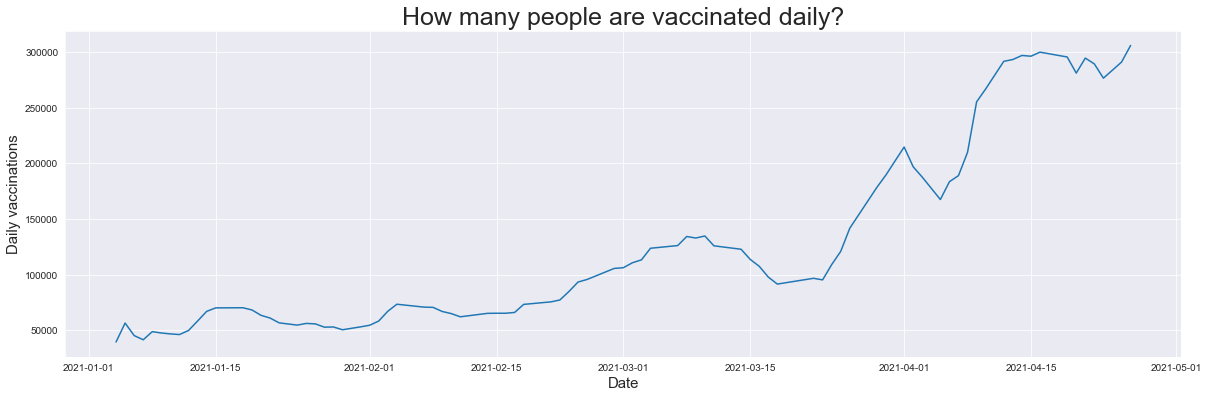

In [66]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,6))
sns.lineplot(data=vacc_Spain['daily_vaccinations'])
plt.title('How many people are vaccinated daily?',fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Daily vaccinations', fontsize=15)
plt.show()

### 2. Pacientes totalmente vacunados vs no vacunados totalmente

In [67]:
fvacc_Spain = vacc_Spain.people_fully_vaccinated.tail(113)
nfvacc_Spain = vacc_Spain.people_vaccinated.tail(113)

Text(0, 0.5, 'Number of people')

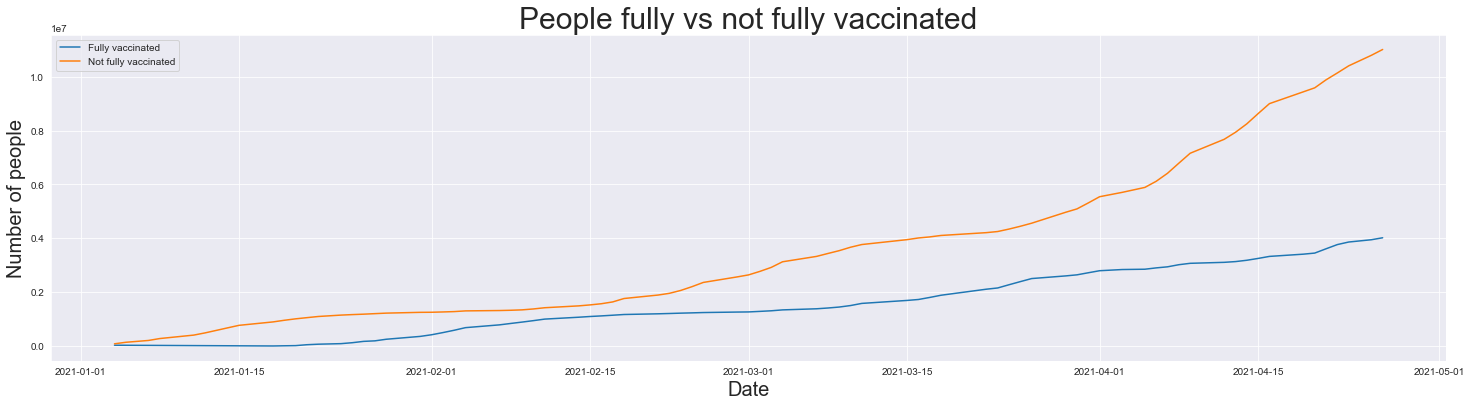

In [68]:
plt.figure(figsize=(25,6))
sns.lineplot(data=fvacc_Spain, label='Fully vaccinated')
sns.lineplot(data=nfvacc_Spain, label='Not fully vaccinated')

plt.title('People fully vs not fully vaccinated', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of people', fontsize=20)